# Monkey classification 

### Using trainsfer learning from  the _inception3_ model  

I use the [**10 Monkey Secied** dataset from kaggle](https://www.kaggle.com/slothkong/10-monkey-species)

This notebook includes code for data preparation and training (fine-tuning) the **inception3** model. The code for data augmentation is stored in another notebook. With augmentation, the model can correctly classify between the ten monkey species with accuracy of ~96%.

Demonstration of the how the result can be found in notebook **monkey_app**.

### 10 monkey species
* n0: Mantled howler (鬃毛吼猴)
* n1: Patas monkey (赤猴)
* n2: Bald uakari (白秃猴)
* n3: Japanese macaque (日本獼猴)
* n4: Pygmy marmoset (倭狨)
* n5: White headed capuchin (捲尾猴)
* n6: Silvery marmoset (銀狨)
* n7: Common squirrel monkey (松鼠猴)
* n8: Black headed night monkey (黑頭夜猴)
* n9: Nilgiri langur (長尾葉猴)

In [3]:
labels = ['n0: Mantled howler (鬃毛吼猴)',
'n1: Patas monkey (赤猴)',
'n2: Bald uakari (白秃猴)',
'n3: Japanese macaque (日本獼猴)',
'n4: Pygmy marmoset (倭狨)',
'n5: White headed capuchin (捲尾猴)',
'n6: Silvery marmoset (銀狨)',
'n7: Common squirrel monkey (松鼠猴)',
'n8: Black headed night monkey (黑頭夜猴)',
'n9: Nilgiri langur (長尾葉猴)']

In [167]:
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import load_model
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
print(tf.__version__)
print(keras.__version__)

1.9.0
2.2.2


### note on installing packages

```
pip install opencv-python
pip install scikit-image
```

(or conda)

In [168]:
import cv2  # for image processing
from skimage.measure import block_reduce # install scikit-image
import scipy.io
## for warnings see discussion at https://github.com/ContinuumIO/anaconda-issues/issues/6678
import os
import tqdm
from sklearn.utils import shuffle

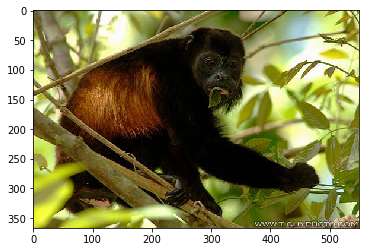

In [169]:
img = cv2.imread('data/training' + '/n0/n0018.jpg')
img.shape
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## image preparation

In [170]:
def image_center_crop(img):
    """
    Makes a square center crop of an img.
    """
    h,w,_ = img.shape
    N = min(h,w) # new h and w
    padh = (h - N) // 2
    padw = (w - N) // 2
    cropped_img = img[ padh: padh + N, padw: padw + N , :]
    return cropped_img
# wrap in one function
def img_prep(img, image_size = 250):
    center_img = image_center_crop(img)
    small_img = cv2.resize(center_img, (image_size, image_size))

    return small_img

### center crop

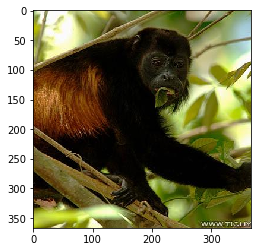

In [171]:
center_img = image_center_crop(img)
center_img.shape
plt.imshow(cv2.cvtColor(center_img, cv2.COLOR_BGR2RGB))
plt.show()

### re-sizing


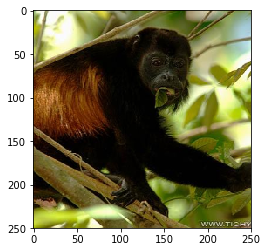

In [172]:
IMG_SIZE = 250
small_img = cv2.resize(center_img, (IMG_SIZE, IMG_SIZE))
small_img.shape
plt.imshow(cv2.cvtColor(small_img, cv2.COLOR_BGR2RGB))
plt.show()

In [86]:
### crop and resize
## try it:
# plt.imshow(cv2.cvtColor(img_prep(img), cv2.COLOR_BGR2RGB))
# plt.show()

## Prepare training data

I use the [**10 Monkey Secied** dataset from kaggle](https://www.kaggle.com/slothkong/10-monkey-species)

* unzip the downloaded .zip file
* unzip training.zip

In [173]:
def read_all_img(path, file_end = '.jpg', image_size = 250):
    '''
    read all images in a directory, and pre-process, packed into a list
    '''
    filenames = os.listdir(path) # list of file names
    imgs = [img_prep(cv2.imread(path + f), image_size) for f in filenames if f.endswith(file_end)]
    return imgs  

In [174]:
datapath1 = 'data/training'
datapath2 = 'data/validation'

In [175]:
X = []
Y = []
for i in range(10):
    path = datapath1 + '/n' + str(i) + '/'
    imgs =  read_all_img(path, file_end = '.jpg', image_size = 250)
    X = X + imgs
    Y = Y + list(np.ones(len(imgs)) * i)
##     plus the augmented data
    imgs =  read_all_img(datapath1 + '/n' + str(i)+ '_aug/', file_end = '.jpg', image_size = 250)
    X = X + imgs
    Y = Y + list(np.ones(len(imgs)) * i)
X,Y = shuffle(X, Y, random_state=0)

n6: Silvery marmoset (銀狨)


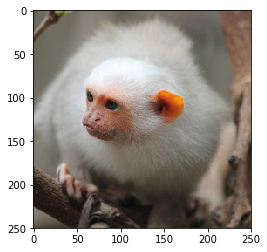

In [176]:
example = 16
print(labels[int(Y[example])])
plt.imshow(cv2.cvtColor(X[example], cv2.COLOR_BGR2RGB))
plt.show()


In [177]:
X_val = []
Y_val = []    
for i in range(10):
    path = datapath2 + '/n' + str(i) + '/'
    imgs =  read_all_img(path, file_end = '.jpg', image_size = 250)
    X_val = X_val + imgs
    Y_val = Y_val + list(np.ones(len(imgs)) * i)
X_val,Y_val = shuffle(X_val, Y_val, random_state=0)

In [178]:
# for x,y in zip(X,Y):
def zip_batch_generator(items1, items2, batch_size):
    """
    Implement batch generator that yields (zipped) items in batches of size batch_size.
    """
    out1 = []
    out2 = []
    for item1, item2 in zip(items1, items2):
        out1.append(item1)
        out2.append(item2)
        if len(out1) == batch_size:
#             out1 = np.stack(out1, axis=0)
#             keras.utils.np_utils.to_categorical(batch_targets, N_CLASSES)
            yield out1, out2
            out1 = []
            out2 = []
    yield out1, out2

In [179]:
# temp = zip_batch_generator([1,2,3,4,5,6,7], ['a','b','c','d','e','f','g'], 3)
# for t1,t2 in temp:
#     print(t1)
#     print(t2)

In [180]:
N_CLASSES = 10

In [181]:
def batch_norm(batch):
    # normalize
    post_img = []
    for img in batch:
        img = img.astype("float32") 
        post_img.append(keras.applications.inception_v3.preprocess_input(img))
    return post_img

In [182]:
def train_generator(items1, items2, batch_size, N_CLASSES = 10):
    while True:
         for batch1, batch2 in zip_batch_generator(items1, items2, batch_size):
                batch_imgs = np.stack(batch_norm(batch1), axis=0)
                batch_targets = keras.utils.np_utils.to_categorical(batch2, N_CLASSES)
                yield batch_imgs, batch_targets

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 250, 250, 3) (3, 10)
class = 2


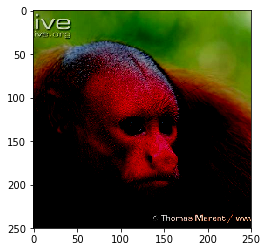

In [183]:
for _ in train_generator(X, Y, 3):
    print(_[0].shape, _[1].shape)
    plt.imshow(cv2.cvtColor(_[0][0], cv2.COLOR_BGR2RGB))
    print('class = ' + str(np.argmax(_[1][0])))
#     plt.imshow(_[0][1])
#     print('class = ' + str(np.argmax(_[1][1])))
    break

# Training

In [111]:
IMG_SIZE = 250

In [185]:
K.clear_session()

In [186]:
def inception():
    # load pre-trained model graph, don't add final layer
    model = keras.applications.InceptionV3(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3),weights='imagenet' )
    # add global pooling just like in InceptionV3
    new_output = keras.layers.GlobalAveragePooling2D()(model.output)
    # add new dense layer for our labels
    new_output = keras.layers.Dense(N_CLASSES, activation='softmax')(new_output)
    model = keras.engine.training.Model(model.inputs, new_output)
    return model

In [187]:
model = inception()
current_ephoch = 0
# load pre-trained weight, take some time...

In [155]:
## very long!
# model.summary()


In [188]:
print(len(model.layers))

313


In [189]:
# set all layers trainable by default and prepare batch norm for fine-tuning
for layer in model.layers:
    layer.trainable = True
    if isinstance(layer, keras.layers.BatchNormalization):
        # we do aggressive exponential smoothing of batch norm 
        # parameters to faster adjust to our new dataset
#         layer.momentum = 0.8
        layer.momentum = 0.5
    
# fix deep layers (fine-tuning only last 50)
for layer in model.layers[:-50]:
    layer.trainable = False

In [190]:
# compile new model
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=2e-3),  # we can take big lr here because we fixed first layers
    metrics=['accuracy']  # report accuracy during training
)

In [191]:
# X_val_b = np.stack(X_val, axis=0)
Y_val_b = keras.utils.np_utils.to_categorical(Y_val, N_CLASSES)

In [196]:
## un-comment below to load model
# model = load_model('monkey.h5')

In [198]:
# fine tune for a few epochs
BATCH_SIZE = 64
current_ephoch += 1
model.fit_generator(
    train_generator(X, Y, BATCH_SIZE), 
    steps_per_epoch=len(Y) // BATCH_SIZE, 
    epochs=1,
    validation_data= train_generator(X_val, Y_val, BATCH_SIZE), 
    validation_steps=len(Y_val) // BATCH_SIZE // 2,
    verbose=1
)

# [loss, acc] = model.evaluate(X_val_b, Y_val_b)
# print('validation acc: ' + str(acc))

print('epoch: ' + str(current_ephoch))

Epoch 1/1
51/51 [==============================] - 545s 11s/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.0497 - val_acc: 0.9688
epoch: 4


In [162]:
# model.save('monkey.h5')
print('Done!')

Done!


In [163]:
np.argmax(model.predict(np.stack(batch_norm(X[314:328]), axis=0)), axis=1)
# model.predict(np.stack(X[114:115], axis=0))

array([0, 4, 2, 6, 9, 1, 3, 3, 6, 9, 1, 2, 5, 6])

In [127]:
Y[314:328]

[0.0, 4.0, 2.0, 6.0, 9.0, 1.0, 3.0, 3.0, 6.0, 9.0, 1.0, 2.0, 5.0, 6.0]

In [199]:
test_accuracy = model.evaluate_generator(
    train_generator(X_val, Y_val, BATCH_SIZE), 
    len(Y) // BATCH_SIZE // 2
)[1]

In [201]:
test_accuracy

0.9632352941176471

In [83]:
# np.stack(X[114:115], axis=0)

In [2]:
# plt.imshow(img_prep(img, 300))
# plt.show()

## note

* normalization is important, [see this](https://stackoverflow.com/questions/47157526/resnet-100-accuracy-during-training-but-33-prediction-accuracy-with-the-same)
* with 1x augmentation and 2 epochs, validation accuracy ~ 0.95 (but stucked)
* with 2x augmentation and 3 epochs, validation accuracy ~ 0.963 (but stucked)
* with 3x augmentation and 4 epochs, validation accuracy ~ 0.967 (but stucked)


In [1]:
example = 25
prepedX = np.stack(batch_norm(X_val[example:example+1]), axis=0)
predict = np.argmax(model.predict(prepedX), axis=1)[0]
print('predicted: ' + labels[int(predict)])
print('labeled:   '+labels[int(Y_val[example])])
plt.imshow(cv2.cvtColor(X_val[example], cv2.COLOR_BGR2RGB))
plt.show()

NameError: name 'np' is not defined

predicted: n6: Silvery marmoset (銀狨)


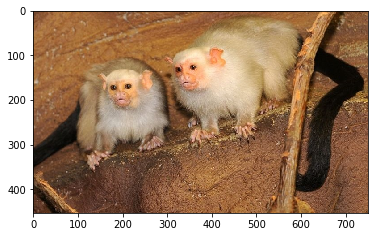

In [153]:
inputX = cv2.imread('data/validation' + '/n6/n6014.jpg')
prepedX = np.stack(batch_norm([img_prep(inputX)]), axis=0)
predict = np.argmax(model.predict(prepedX), axis=1)[0]
print('predicted: ' + labels[int(predict)])
plt.imshow(cv2.cvtColor(inputX, cv2.COLOR_BGR2RGB))
plt.show()